In [ ]:
!pip install openai==0.28
!pip install transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.7 MB/s eta 0:00:00


In [ ]:
import openai
import json
from google.colab import drive

# Load your API key
openai.api_key = 'sk-proj-9ssvthWTPIAEWpgdnpfMT3BlbkFJGQArbYHI4CDC1uoejEVE'

# Mount Google Drive
drive.mount('/content/drive')

# Load the defects4j dataset
with open('/content/drive/MyDrive/Repair/defects4j-sf.json') as f:
    dataset = json.load(f)

# Example of how the data looks
print(json.dumps(dataset['Chart-1'], indent=4))


Mounted at /content/drive
{
    "buggy": "public LegendItemCollection getLegendItems() {\n    LegendItemCollection result = new LegendItemCollection();\n    if (this.plot == null) {\n        return result;\n    }\n    int index = this.plot.getIndexOf(this);\n    CategoryDataset dataset = this.plot.getDataset(index);\n    if (dataset != null) {\n        return result;\n    }\n    int seriesCount = dataset.getRowCount();\n    if (plot.getRowRenderingOrder().equals(SortOrder.ASCENDING)) {\n        for (int i = 0; i < seriesCount; i++) {\n            if (isSeriesVisibleInLegend(i)) {\n                LegendItem item = getLegendItem(index, i);\n                if (item != null) {\n                    result.add(item);\n                }\n            }\n        }\n    }\n    else {\n        for (int i = seriesCount - 1; i >= 0; i--) {\n            if (isSeriesVisibleInLegend(i)) {\n                LegendItem item = getLegendItem(index, i);\n                if (item != null) {\n              

In [ ]:
def prepare_training_data(dataset):
    training_data = []
    for key, value in dataset.items():
        buggy_code = value['buggy'][:1000]  # Truncate buggy code to 1000 characters
        fixed_code = value['fix'][:500]  # Truncate fixed code to 500 characters
        error_msg = value['trigger_test'][list(value['trigger_test'].keys())[0]]['clean_error_msg'][:500]  # Truncate error message to 500 characters
        training_data.append({
            "prompt": f"Buggy code:\n{buggy_code}\n\nError:\n{error_msg}\n\nFixed code:\n",
            "completion": f"{fixed_code}\n"
        })
    return training_data

training_data = prepare_training_data(dataset)

# Example of the training data
print(json.dumps(training_data[0], indent=4))


{
    "prompt": "Buggy code:\npublic LegendItemCollection getLegendItems() {\n    LegendItemCollection result = new LegendItemCollection();\n    if (this.plot == null) {\n        return result;\n    }\n    int index = this.plot.getIndexOf(this);\n    CategoryDataset dataset = this.plot.getDataset(index);\n    if (dataset != null) {\n        return result;\n    }\n    int seriesCount = dataset.getRowCount();\n    if (plot.getRowRenderingOrder().equals(SortOrder.ASCENDING)) {\n        for (int i = 0; i < seriesCount; i++) {\n            if (isSeriesVisibleInLegend(i)) {\n                LegendItem item = getLegendItem(index, i);\n                if (item != null) {\n                    result.add(item);\n                }\n            }\n        }\n    }\n    else {\n        for (int i = seriesCount - 1; i >= 0; i--) {\n            if (isSeriesVisibleInLegend(i)) {\n                LegendItem item = getLegendItem(index, i);\n                if (item != null) {\n                    result

In [ ]:
def repair_code(prompt):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=150,  # Adjust the token limit if needed
        n=1,
        stop=None,
        temperature=0.5,
    )
    return response.choices[0].message['content'].strip()

# Test the function with an example prompt
example_prompt = training_data[0]['prompt']
fixed_code = repair_code(example_prompt)
print(fixed_code)


Here is the fixed code for the issue you mentioned:

```java
public LegendItemCollection getLegendItems() {
    LegendItemCollection result = new LegendItemCollection();
    if (this.plot == null) {
        return result;
    }
    int index = this.plot.getIndexOf(this);
    CategoryDataset dataset = this.plot.getDataset(index);
    if (dataset == null) {
        return result;
    }
    int seriesCount = dataset.getRowCount();
    if (plot.getRowRenderingOrder().equals(SortOrder.ASCENDING)) {
        for (int i = 0; i < seriesCount; i++) {
            if (isSeriesVisibleInLegend(i)) {
                LegendItem item = getLegendItem(index, i);


In [ ]:
!pip install nltk sklearn


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import nltk
from nltk import word_tokenize
from sklearn.metrics import precision_score, recall_score, f1_score
from difflib import SequenceMatcher

nltk.download('punkt')

def get_token_matches(expected_tokens, predicted_tokens):
    matcher = SequenceMatcher(None, expected_tokens, predicted_tokens)
    matches = matcher.get_matching_blocks()
    return matches

def pad_sequences(y_true, y_pred):
    max_length = max(len(y_true), len(y_pred))
    y_true.extend([0] * (max_length - len(y_true)))
    y_pred.extend([0] * (max_length - len(y_pred)))
    return y_true, y_pred

def evaluate_model(training_data):
    correct_fixes = 0
    total = len(training_data)
    precisions = []
    recalls = []
    f1s = []

    for data in training_data:
        prompt = data['prompt']
        expected_fix = data['completion'].strip()
        predicted_fix = repair_code(prompt)

        # Tokenize the expected and predicted fixes
        expected_tokens = word_tokenize(expected_fix)
        predicted_tokens = word_tokenize(predicted_fix)

        # Initialize binary labels for precision, recall, and F1 score calculations
        y_true = [1 if token in expected_tokens else 0 for token in predicted_tokens]
        y_pred = [1 if token in predicted_tokens else 0 for token in expected_tokens]

        # Pad sequences to the same length
        y_true, y_pred = pad_sequences(y_true, y_pred)

        if len(y_true) > 0 and len(y_pred) > 0:
            precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
            recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
            f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)

        # Check if the token lists are the same for accuracy
        if expected_tokens == predicted_tokens:
            correct_fixes += 1

    avg_precision = sum(precisions) / len(precisions) if precisions else 0
    avg_recall = sum(recalls) / len(recalls) if recalls else 0
    avg_f1 = sum(f1s) / len(f1s) if f1s else 0

    return avg_precision, avg_recall, avg_f1

# Evaluate the model
precision, recall, f1 = evaluate_model(training_data)
print(f"Model Precision: {precision * 100:.2f}%")
print(f"Model Recall: {recall * 100:.2f}%")
print(f"Model F1 Score: {f1 * 100:.2f}%")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Model Precision: 43.53%
Model Recall: 44.71%
Model F1 Score: 43.20%


In [ ]:
!pip install matplotlib


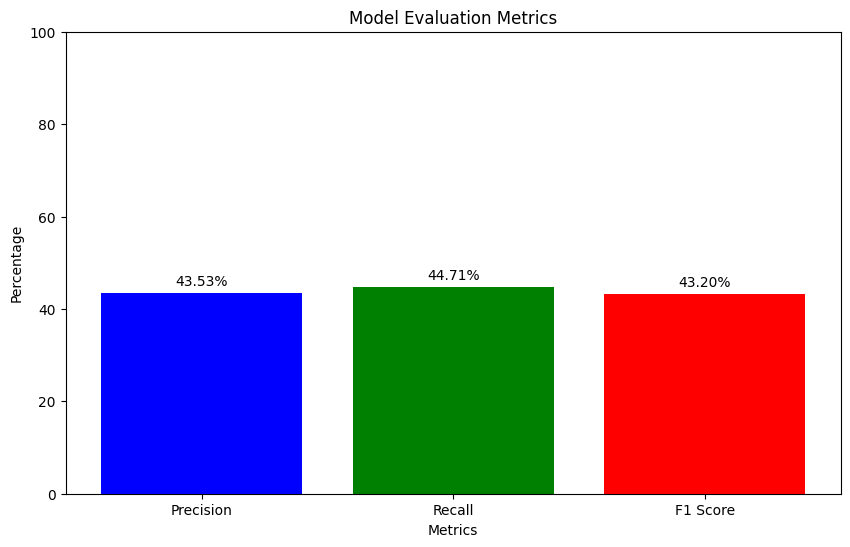

In [ ]:
import matplotlib.pyplot as plt

# Assuming the precision, recall, and f1 variables are already defined
metrics = ['Precision', 'Recall', 'F1 Score']
values = [precision * 100, recall * 100, f1 * 100]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.ylim(0, 100)

for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom')

plt.xlabel('Metrics')
plt.ylabel('Percentage')
plt.title('Model Evaluation Metrics')
plt.show()


In [ ]:
def repair_new_buggy_code(buggy_code, error_msg):
    prompt = f"Buggy code:\n{buggy_code[:1000]}\n\nError:\n{error_msg[:500]}\n\nFixed code:\n"
    return repair_code(prompt)

# Example usage
new_buggy_code = """
public LegendItemCollection getLegendItems() {
    LegendItemCollection result = new LegendItemCollection();
    if (this.plot == null) {
        return result;
    }
    int index = this.plot.getIndexOf(this);
    CategoryDataset dataset = this.plot.getDataset(index);
    if (dataset != null) {
        return result;
    }
    int seriesCount = dataset.getRowCount();
    if (plot.getRowRenderingOrder().equals(SortOrder.ASCENDING)) {
        for (int i = 0; i < seriesCount; i++) {
            if (isSeriesVisibleInLegend(i)) {
                LegendItem item = getLegendItem(index, i);
                if (item != null) {
                    result.add(item);
                }
            }
        }
    }
    else {
        for (int i = seriesCount - 1; i >= 0; i--) {
            if (isSeriesVisibleInLegend(i)) {
                LegendItem item = getLegendItem(index, i);
                if (item != null) {
                    result.add(item);
                }
            }
        }
    }
    return result;
}
"""
new_error_msg = "Potential NPE in AbstractCategoryItemRender.getLegendItems()"

fixed_code = repair_new_buggy_code(new_buggy_code, new_error_msg)
print(fixed_code)


It looks like there are a couple of issues in the provided code snippet. Here's the fixed code with the identified issues resolved:

```java
public LegendItemCollection getLegendItems() {
    LegendItemCollection result = new LegendItemCollection();
    if (this.plot == null) {
        return result;
    }
    int index = this.plot.getIndexOf(this);
    CategoryDataset dataset = this.plot.getDataset(index);
    if (dataset == null) {
        return result;
    }
    int seriesCount = dataset.getRowCount();
    if (plot.getRowRenderingOrder().equals(SortOrder.ASCENDING)) {
        for (int i = 0; i < seriesCount; i++) {
            if (isSeriesVisibleInLegend


In [ ]:
# New buggy code and error message
new_buggy_code = """
public int divideNumbers(int a, int b) {
    return a / b;
}
"""
new_error_msg = "ArithmeticException: / by zero"

# Function to repair new buggy code
def repair_new_buggy_code(buggy_code, error_msg):
    prompt = f"Buggy code:\n{buggy_code}\n\nError:\n{error_msg}\n\nFixed code:\n"
    return repair_code(prompt)

# Test the function with new buggy code
fixed_code = repair_new_buggy_code(new_buggy_code, new_error_msg)
print("Fixed Code:\n", fixed_code)


Fixed Code:
 To fix the issue of dividing by zero, you can add a check to ensure that the divisor (b) is not zero before performing the division operation. Here is the fixed code:

```java
public int divideNumbers(int a, int b) {
    if (b == 0) {
        throw new IllegalArgumentException("Cannot divide by zero");
    }
    return a / b;
}
```

By adding this check, the method will throw an exception if the divisor is zero, preventing the ArithmeticException from occurring.
